In [1]:
import os, sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import epitome.preprocess.iio as io
import tensorflow as tf
%matplotlib inline

sess = tf.InteractiveSession()

# Use MNIST data as examples (may take some time).
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets('/tmp/mnist_train')

ImportError: No module named iio

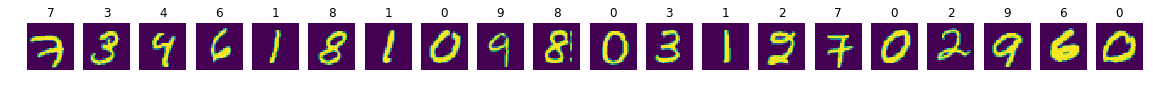

In [2]:
# Inspect a few samples.

num_examples = 20
fig, ax = plt.subplots(1, num_examples, figsize=[num_examples, 1])

for i in range(num_examples):
    X = tf.reshape(mnist.train.images[i], [28, 28])
    y = mnist.train.labels[i]
    ax[i].imshow(X.eval())
    ax[i].set_title(y)
    ax[i].axis('off')

In [3]:
# Create a single training example.

def make_example(X, y):
    X = tf.image.encode_png(tf.cast(X * 254, tf.uint8))
    feature_dict = {
        'image/encoded': io.make_bytes_feature([X.eval()]),
        'image/format': io.make_bytes_feature(['png']),
        'label': io.make_int64_feature([y])
    }
    return io.make_example(feature_dict)

X = tf.reshape(mnist.train.images[0], [28, 28, 1])
y = mnist.train.labels[0]

example = make_example(X.eval(), y)
example

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000\034\000\000\000\034\010\000\000\000\000Wf\200H\000\000\000\351IDAT(\221c`\0306\200\021\211\235\360\377\255\346\361#h\222\221\006\211\014\014\014\014\014\002\014\177\331\276\177\273\034\376\006I\276\373\327_\024\260G\014I\347C\231K\337\031\030\030\216lb```p\216S`\330\037\201\320\253\032\310\203d\216\342\225\277\177\213p:1\370\357\337\227P&\023>\257`Hfz20p\032a*\224(y\374\370\361\237\277\177\377\376}\017\021`\201K9\033\247*\301\330\363Pu\251\354\372\363\367\357\337{g\317z9_\373\373\267\004E\256\340\326\337\217\217\212\"\344\030\030\030\030\216\377\375\240\201\"\271\342\357z[(S\377\031\334+P X\rg\006\377\375\273\024\207\327\030\030\272\376\276\265\300%w\361\347\337\34585~\374\373\016\247\306\210_\037Bq\311\261\234\375:\007\247\241\314%.8\345\320\000\000\365\272^\322\2214\312e\000\000\000\000IEND\256B`\202"
      }
    }
  }
  feature {
    key: "im

In [4]:
# Write 100 examples to a TFRecord.

def make_examples(num_examples):
    for i in range(num_examples):
        X = tf.reshape(mnist.train.images[i], [28, 28, 1])
        y = mnist.train.labels[i]
        yield make_example(X.eval(), y)
    
examples = make_examples(100)
io.write_tfrecord(examples, '/tmp/examples.tfrecord')

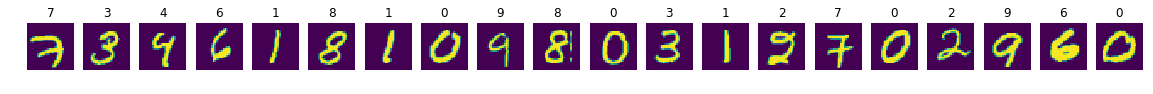

In [5]:
# Read the TFRecords back in and decode an example.

examples = io.read_tfrecord('/tmp/examples.tfrecord')

num_examples = 20
fig, ax = plt.subplots(1, num_examples, figsize=[num_examples, 1])

for i in range(num_examples):
    example = examples.next()  # Get the next example from the generator
    assert io.get_bytes_list(example, 'image/format')[0] == 'png'
    X = tf.image.decode_png(io.get_bytes_list(example, 'image/encoded')[0])
    y = io.get_int64_list(example, 'label')[0]
    ax[i].imshow(X[:,:,0].eval())
    ax[i].set_title(y)
    ax[i].axis('off')

In [4]:
# Can we use Tensorflow-Slim?

slim = tf.contrib.slim

keys_to_features = {
    'image/encoded': tf.FixedLenFeature(dtype=tf.string, shape=[]),
    'image/format': tf.FixedLenFeature(dtype=tf.string, shape=[]),
    'label': tf.FixedLenFeature(dtype=tf.int64, shape=[]),
}

items_to_handlers = {
    'image': slim.tfexample_decoder.Image(
        'image/encoded', 'image/format', channels=1),
    'label': slim.tfexample_decoder.Tensor('label'),
}

decoder = slim.tfexample_decoder.TFExampleDecoder(
    keys_to_features,
    items_to_handlers)

dataset = slim.dataset.Dataset(
    data_sources=['/tmp/examples.tfrecord'],
    reader=tf.TFRecordReader,
    decoder=decoder,
    num_samples=100,
    items_to_descriptions=None)

provider = slim.dataset_data_provider.DatasetDataProvider(dataset)

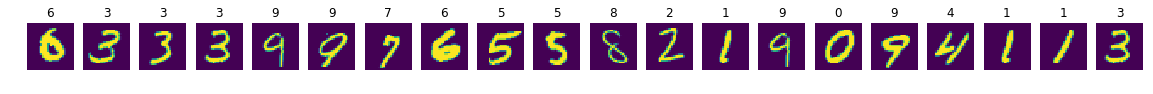

In [9]:
# Querying the data provider.

X, y = provider.get(['image', 'label'])
X = X[:,:,0]  # [28, 28, 1] ==> [28, 28]

num_examples = 20
fig, ax = plt.subplots(1, num_examples, figsize=[num_examples, 1])

with tf.train.MonitoredSession() as sess:
    i = 0
    while i < num_examples and not sess.should_stop():
        X_, y_ = sess.run([X, y])
        ax[i].imshow(X_)
        ax[i].set_title(y_)
        ax[i].axis('off')
        i += 1

In [12]:
# How about making batches?

X, y = provider.get(['image', 'label'])
X = tf.reshape(X, [28, 28])  # Batching requires fully-evaluated shape.
X, y = tf.train.shuffle_batch(
    [X, y], batch_size=16, capacity=100, min_after_dequeue=0)

with tf.train.MonitoredSession() as sess:
    X_, y_ = sess.run([X, y])
    print X_.shape # Should be shape [16, 28, 28]
    print y_.shape # Should be shape [16,]

(16, 28, 28)
(16,)
